## Analysis Demo
This notebook demonstrates how to use the provided code to easily scan new data for neuromodulatory involvement and eveluate the contribution of individual receptors 

Here we reanalyse the data from study 1, as reported in the manuscript, but this can be changed by adapting the paths in config.demo_config


In [1]:
#load packages
import os
from glob import glob
import pickle
from pathlib import Path
from nilearn import plotting, datasets, image
from nilearn import surface
from config.loader_demo import load_config
from utils.main_funcs import nii_to_cortical_voxel_array
from analysis.regression_cv_with_spintest import prepare_spins, run_reg_cv_with_spin
from analysis.variance_explained import run_comp_null, run_predict_from_beta, run_group_ratio_summary
from analysis.receptor_effect_map_relationship  import run_dominance_analysis, load_dominance_data, plot_dominance_bars

#load demo specific params and paths 

data need to have a specific name 
will be be resampled to mni space (2mm resolution) which correpsonds to the receptor data provided. 

The structure of the loading class allows us to compare multiple datatsets in the same data folder that might need different config files

Note: due to copyright reasons we are here using only the recptors provided by Hansen et al.  

In [2]:
params, paths, rec = load_config('study_1', return_what='all')


## effect arrays for further analysis

In [3]:
# create effect arrays to be used in further analysis

# Find all .nii.gz files containing params.latent_var
all_nii = glob(os.path.join(paths.beta_dir, "*.nii.gz"))
matching_nii = [
    f for f in all_nii
    if any(lv in os.path.basename(f) for lv in params.latent_vars)
]

print(f"Found {len(matching_nii)} matching files.")

# Loop through and process
for nii_file in matching_nii:

    array, mask = nii_to_cortical_voxel_array(os.path.join(paths.beta_dir, nii_file))

    base = os.path.basename(nii_file).replace("_map.nii.gz", "")
    out_path = os.path.join(paths.beta_dir, f"{base}.pickle")
    with open(out_path, "wb") as f:
            pickle.dump(array, f)

Found 26 matching files.


## plot example subject

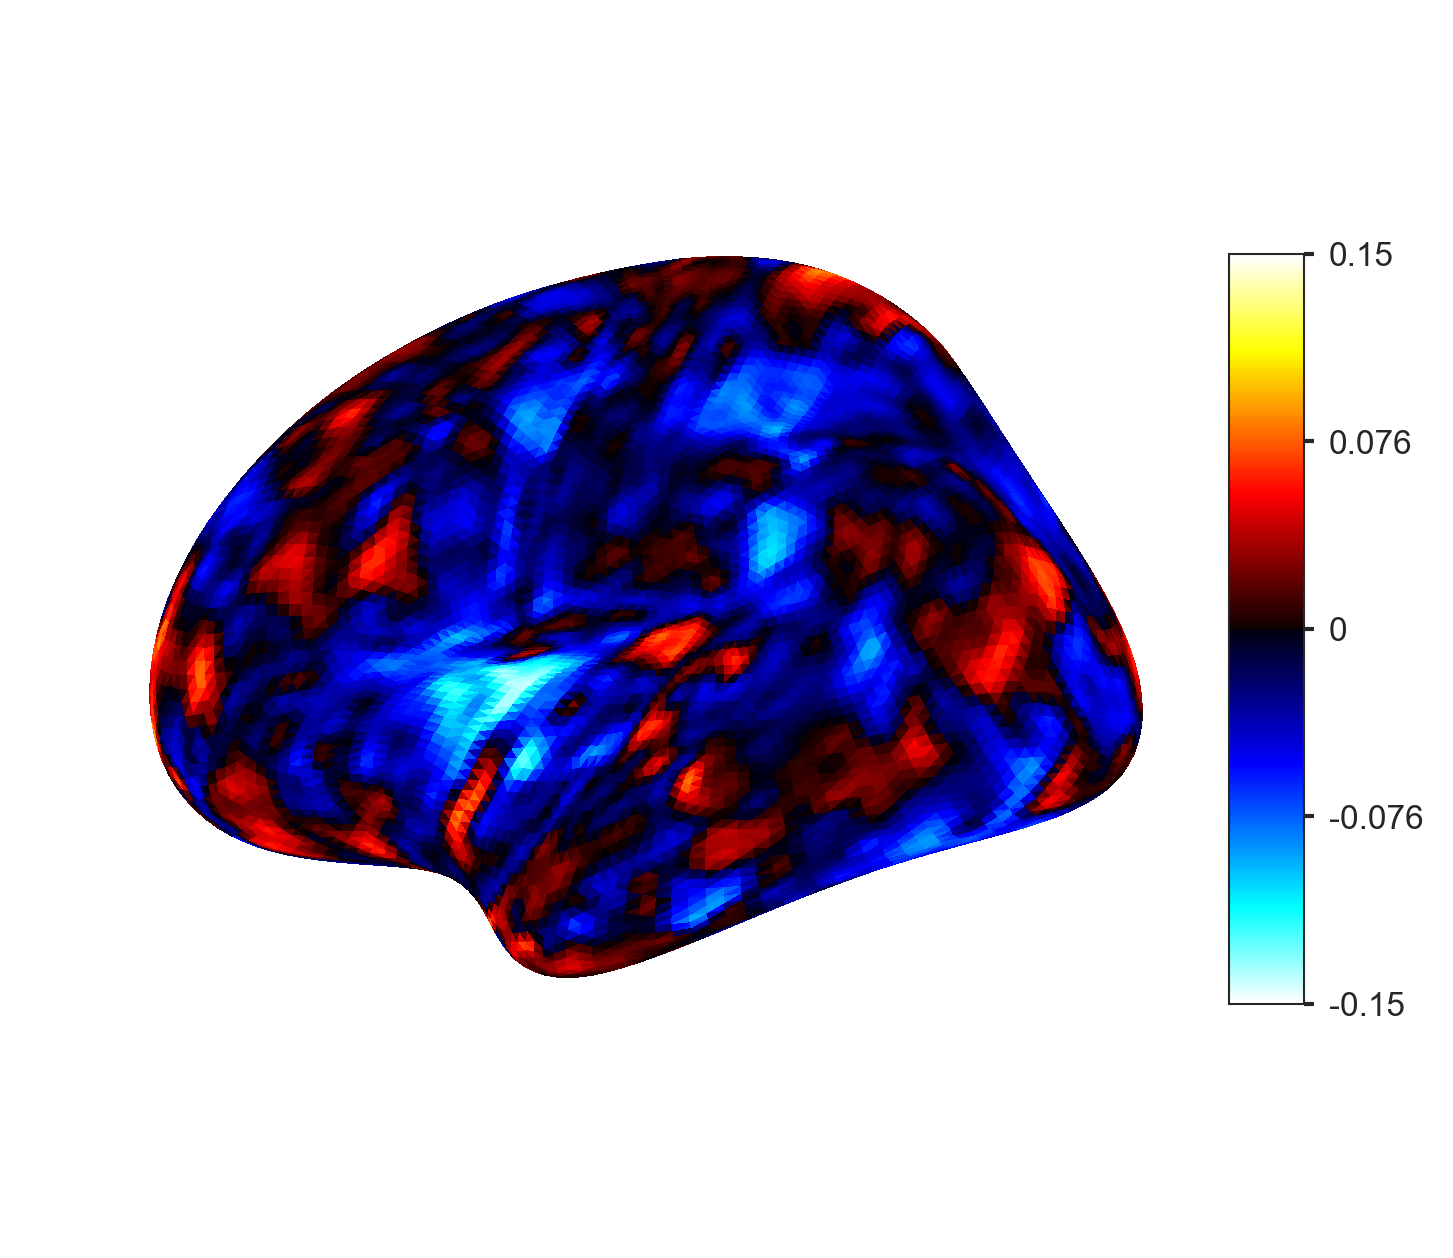

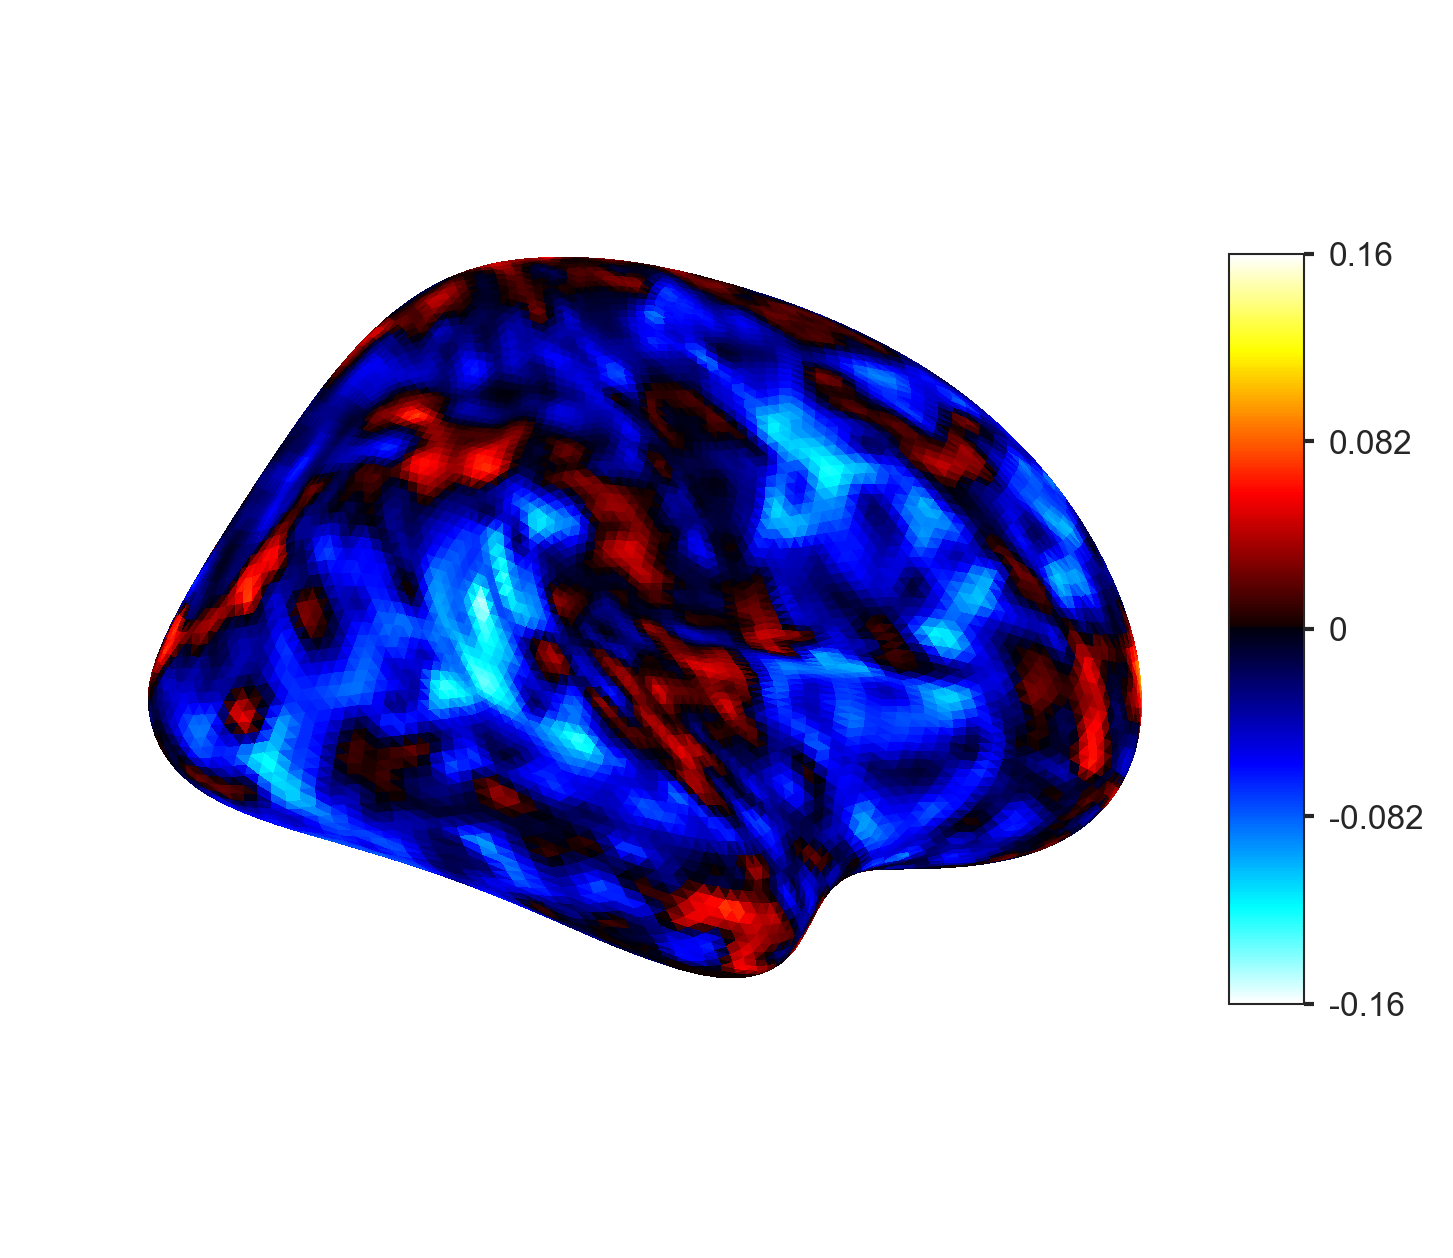

In [4]:
#plot example subject
# Load the first NIfTI image
example_file = image.load_img(os.path.join(paths.beta_dir, matching_nii[0]))

# Load 3D NIfTI
vol_img = image.load_img(example_file)

# Sample volume onto fsaverage surface
fsaverage = datasets.fetch_surf_fsaverage()
texture_left = surface.vol_to_surf(vol_img, fsaverage.pial_left)
texture_right = surface.vol_to_surf(vol_img, fsaverage.pial_right)


# Plot the statistical map on the left hemisphere
plotting.plot_surf_stat_map(
    surf_mesh=fsaverage.infl_left,   # inflated left hemisphere mesh
    stat_map=texture_left,
    hemi='left',
    view='lateral',
    colorbar=True
)

# Plot the right hemisphere if you want
plotting.plot_surf_stat_map(
    surf_mesh=fsaverage.infl_right,
    stat_map=texture_right,
    hemi='right',
    view='lateral',
    colorbar=True
)

plotting.show()


## Run regression and null model for further analysis 

ATTENTION: the cross-validation ra few minutes, when combined with the null spins it becomes very long. 
For the demo, this step can be skiped as the values are provided in the results/regression folder for each of the datasets used in the manuscript

In [ ]:
spins = prepare_spins(paths, rec, n_spins=1000)

run_reg_cv_with_spin(params, paths, rec, spins, output_dir=os.path.join(paths.results_dir, 'regressions'), run_spin = True)

--- CV for EncodeProb and confidence ---
--- CV for subject 0 out of 26 ---
--- CV for subject 1 out of 26 ---
--- CV for subject 2 out of 26 ---
--- CV for subject 3 out of 26 ---
--- CV for subject 4 out of 26 ---
--- CV for subject 5 out of 26 ---
--- CV for subject 6 out of 26 ---
--- CV for subject 7 out of 26 ---
--- CV for subject 8 out of 26 ---
--- CV for subject 9 out of 26 ---
--- CV for subject 10 out of 26 ---
--- CV for subject 11 out of 26 ---
--- CV for subject 12 out of 26 ---
--- CV for subject 13 out of 26 ---
--- CV for subject 14 out of 26 ---
--- CV for subject 15 out of 26 ---
--- CV for subject 16 out of 26 ---
--- CV for subject 17 out of 26 ---
--- CV for subject 18 out of 26 ---
--- CV for subject 19 out of 26 ---
--- CV for subject 20 out of 26 ---
--- CV for subject 21 out of 26 ---
--- CV for subject 22 out of 26 ---
--- CV for subject 23 out of 26 ---
--- CV for subject 24 out of 26 ---
--- CV for subject 25 out of 26 ---
--- Spin test for EncodeProb and 

## Variance explained tested for significance.

In [4]:
run_comp_null(params, data_dir=os.path.join(paths.results_dir, 'regressions'), to_file=False)

EncodeProb and confidence:
t-value: nan
p-value: nan
FDR-corrected p-value: nan
df: -1



## Ratio of explained variance
we wirst calculate the maximum explainable variance 

In [ ]:
#print percent explained variance
#option to skip the comparison to the language datatset

In [5]:
run_predict_from_beta(params.tasks, params, paths, os.path.join(paths.results_dir, 'max_variance'), to_file=False)


EncodeProb: maximum variance explained in analysis

confidence: 0.12174548094089215, sem: 0.014758012457847322




In [ ]:
run_group_ratio_summary(params, data_dir=paths.results_dir, to_file=False)

AttributeError: task

## Evaluate the contribution of individual receptors

### Run dominance analysis

ATTENTION: this step is very computationally demanding. For the demo, this step can be skiped as the values are provided in the results/dominance folder for each of the datasets used in the manuscript.

In [ ]:
##uncomment this to run the dominance analysis
run_dominance_analysis(
            params=params,
            paths=paths,
            rec=rec,
            model_type="linear",
            start_at=0,
            num_workers=4,
            output_dir=os.path.join(paths.results_dir, 'dominance') 
        )

### plot dominance results

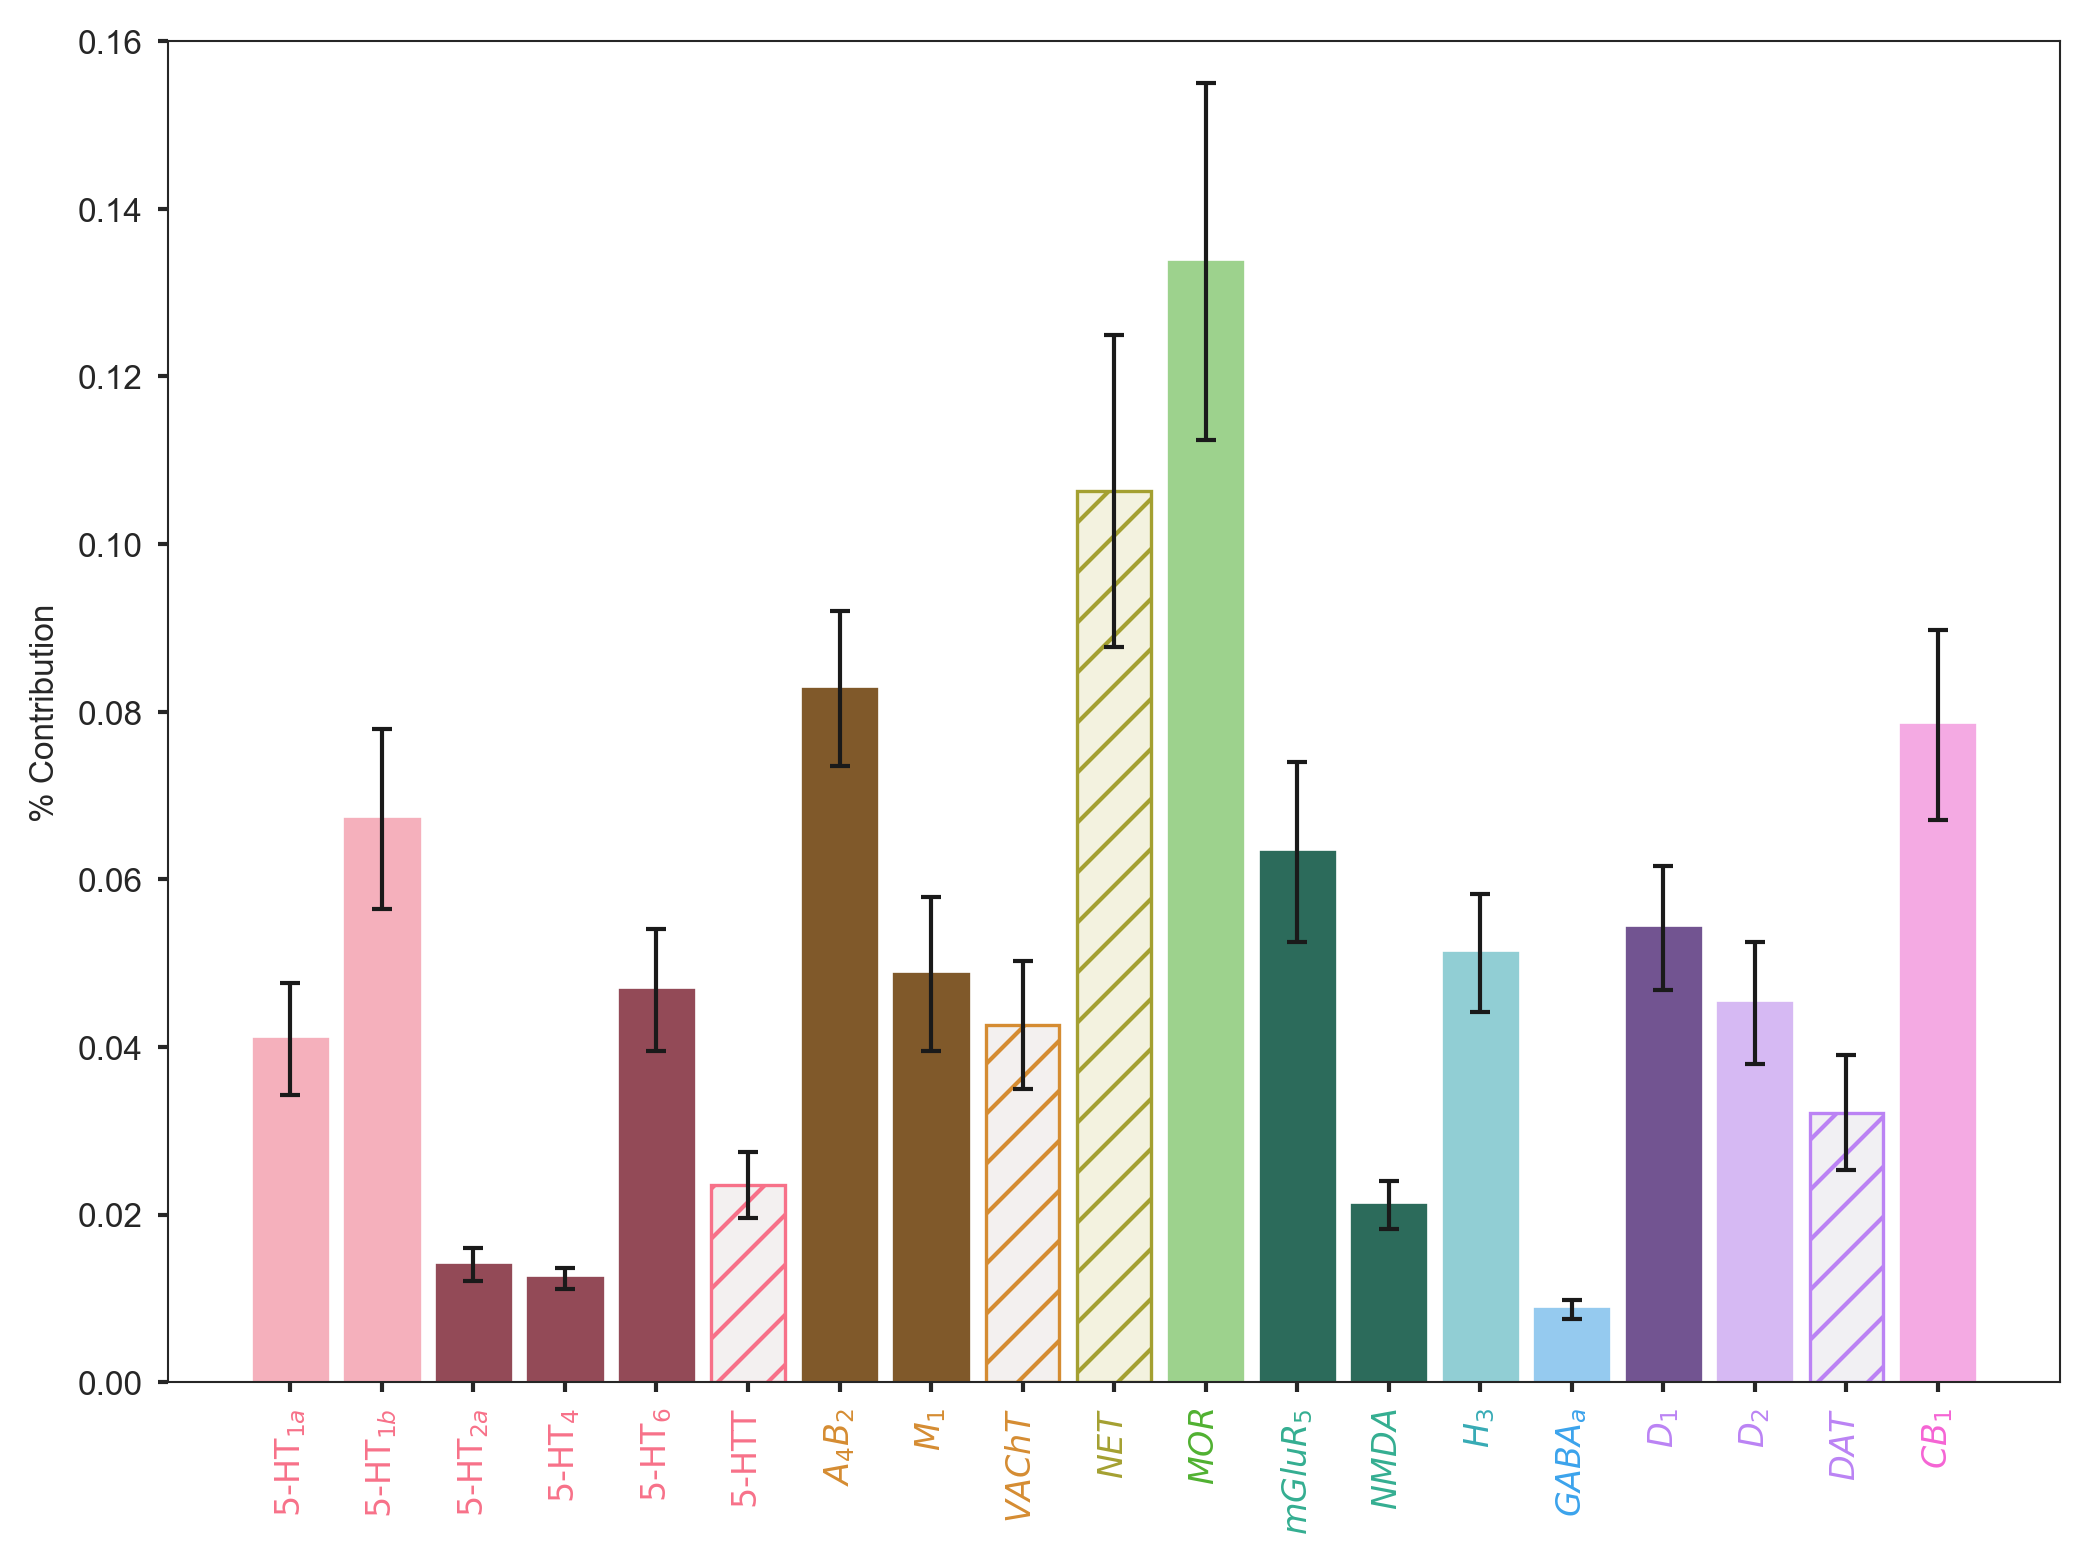

In [4]:
for latent_var in params.latent_vars:
    df = load_dominance_data(params, paths, latent_var, model_type='linear')
    plot_dominance_bars(df, rec.receptor_groups, rec.receptor_class, rec.receptor_label_formatted, title=None)

## Optional: explore receptors 

In [ ]:
#plot the receptors from volume?

In [ ]:
#plot the correlation matrix?